In [1]:
# Authenticate to use Google Cloud services
from google.colab import auth
auth.authenticate_user()

# Building a Semantic Layer in Python (LookML-style)

### Objective
In this notebook, we define a reusable **semantic layer** in Python called `ExploreBy`, which mimics the functionality of LookML (used in Looker).

We use `ExploreBy` to:
- Connect to BigQuery
- Run SQL queries to fetch funnel data (view → add to cart → checkout → purchase)
- Display results grouped by a level in a dimension (e.g., `category` in `device`)
- Visualise the funnel

---

### Why is This a Semantic Layer?

A **semantic layer**:
- Defines reusable logic (like dimensions and metrics)
- Abstracts raw SQL for analysts and business users
- Allows consistent, readable, and centralized data exploration

In LookML, this would look like:

```lookml
explore: ecommerce_events {
  view_name: events

  dimension: device_category {
    sql: ${TABLE}.device_category ;;
  }

  measure: viewed {
    type: count
    filters: { field: event_name, value: "view_item" }
  }

  measure: added_to_cart {
    type: count
    filters: { field: event_name, value: "add_to_cart" }
  }

  measure: checkout_started {
    type: count
    filters: { field: event_name, value: "begin_checkout" }
  }

  measure: purchased {
    type: count
    filters: { field: event_name, value: "purchase" }
  }
}


### Section 1: Semantic Layer Class with SQL + Visualization

In [45]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class ExploreBy: # The point of using class is to make the module scalable to any other future dimension
  """
  project_id: str, you may find your own project id at your google cloud console: console.cloud.google.com
  dataset: str, Dataset ID from BigQuery, e.g., 'bigquery-public-data.google_analytics_sample'
  table: str, Table ID from BigQuery, e.g., 'ga_sessions_20210129'
  dimension: str, dimension name you want to explore, e.g., 'device'
  level: str, level of the dimension, e.g., 'category'
  """
  def __init__(self, dimension, level, project_id='XXX', dataset='bigquery-public-data.ga4_obfuscated_sample_ecommerce', table='events_20210129'):
    self.dimension = dimension
    self.level = level
    self.dataset = dataset
    self.table = table
    self.project_id = project_id
    self.client = bigquery.Client(self.project_id)

  def fetch_funnel_data(self):
    """
    Query BigQuery to retrieve funnel-stage counts grouped by the selected dimension.
    Returns a Pandas DataFrame.
    """
    # SQL query
    query = f"""
    SELECT
      {self.dimension}.{self.level} AS dimension_value,
      COUNTIF(event_name = 'view_item') AS Viewed,
      COUNTIF(event_name = 'add_to_cart') AS AddedToCart,
      COUNTIF(event_name = 'begin_checkout') AS CheckoutStarted,
      COUNTIF(event_name = 'purchase') AS Purchased
    FROM `{self.dataset}.{self.table}`
    WHERE {self.dimension}.{self.level} IS NOT NULL
    GROUP BY dimension_value
    ORDER BY Viewed DESC
    """
    df = self.client.query(query).to_dataframe()
    return df

  def plot_funnel(self, df):
    """
    Plot funnel data using Matplotlib and Seaborn, paralleling the functionality of Looker.
    """
    df_melted = df.melt(id_vars='dimension_value', var_name='stage', value_name='count')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melted, x='count', y='dimension_value', hue='stage')
    plt.title(f'User Funnel by {self.dimension.capitalize()} (Table: {self.table})')
    plt.xlabel('User Count')
    plt.ylabel(self.dimension.capitalize())
    plt.legend(title='Funnel Stage', loc='best', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


### Section 2: Use the Semantic Layer

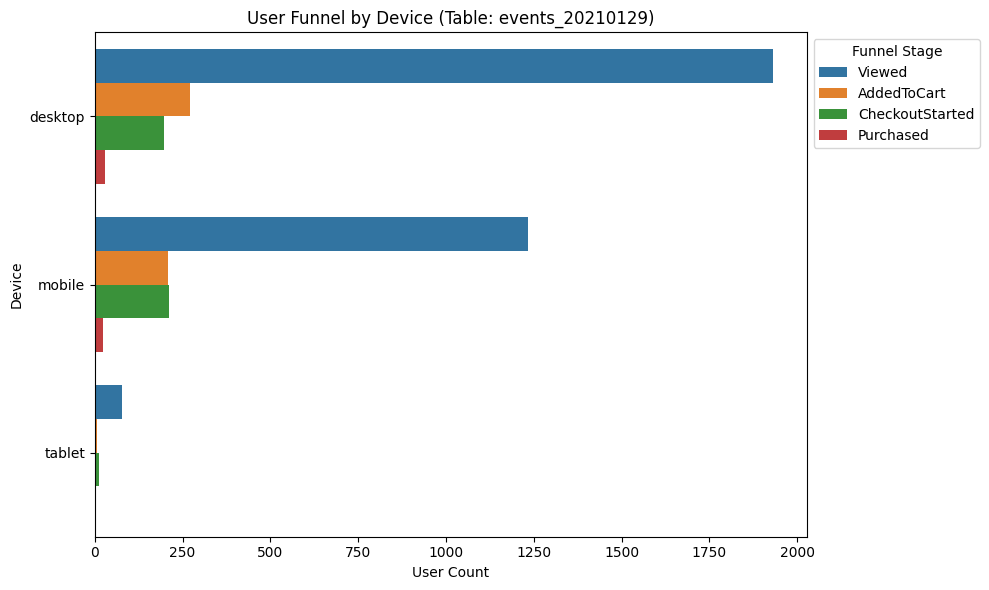

,dimension_value,Viewed,AddedToCart,CheckoutStarted,Purchased
0,desktop,1930,272,198,29
1,mobile,1234,208,211,22
2,tablet,78,6,12,3


In [46]:
# Initialize the semantic layer with dimension of interest
# Fee free to explore any nested dimension
# Example: ["geo","country"], ["geo", "continent"], ["device","category"], ["traffic_source","medium"]
explorer = ExploreBy(dimension='device',level='category')

# Fetch the funnel data using SQL inside the class
df = explorer.fetch_funnel_data()

# Visualize the funnel
explorer.plot_funnel(df)

# Show the dataframe
df.head()


## Why This Semantic Layer Helps

By building the `ExploreBy` class as a **semantic layer**, we:

- **Abstract Complexity:** Instead of writing raw SQL queries every time, users interact with intuitive Python code and simple dimension & level names (like `category` in `device`).  
- **Centralize Logic:** The logic for fetching and processing funnel data is wrapped inside reusable methods, making it easier to maintain and extend.  
- **Make Data Accessible:** Non-technical users or analysts can quickly explore different dimensions without worrying about the underlying database schema or SQL syntax.   

This Python semantic layer mirrors what LookML does in Looker; that is, it defines a business-friendly model on top of raw data. BUT here it is fully transparent and flexible within Python.

Overall, this approach turns complex raw data into clean, ready-to-analyze datasets with a friendly interface--exactly what a semantic layer is all about!
